In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [2]:
symbol = "BNBUSDT"
if not Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

df = pd.read_csv(file_path, parse_dates=['Time'])

df = df.drop(columns=["Unnamed: 0"], errors='ignore')

In [3]:
lst_input = ["VPIN", "Roll", "RollImpact", "KyleLambda", "AmihudLambda"]
list_output = ["SpreadChangeSign", "RealizedVolatilitySign", "JB_ChangeSign", "AR_ChangeSign", "SkewnessSign", "KurtosisSign", "ReturnsSign", "MASign"]

# Khảo sát bộ data

In [4]:
# Chỉ giữ lại các cột cần dùng
df = df[lst_input + list_output]

In [5]:
df.shape

(637, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VPIN                    588 non-null    float64
 1   Roll                    586 non-null    float64
 2   RollImpact              586 non-null    float64
 3   KyleLambda              587 non-null    float64
 4   AmihudLambda            587 non-null    float64
 5   SpreadChangeSign        587 non-null    float64
 6   RealizedVolatilitySign  537 non-null    float64
 7   JB_ChangeSign           537 non-null    float64
 8   AR_ChangeSign           537 non-null    float64
 9   SkewnessSign            537 non-null    float64
 10  KurtosisSign            537 non-null    float64
 11  ReturnsSign             586 non-null    float64
 12  MASign                  637 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 64.8 KB


- Bộ dữ liệu có những dòng dữ liệu null do quá trình tính toán bằng rolling

In [7]:
# Xóa những dòng có giá trị null
df = df.dropna()
df.shape

(537, 13)

# PHÂN TÍCH BIẾN ĐẦU VÀO

### Thống kê mô tả của các biến đầu vào cho mô hình

In [8]:
pd.DataFrame(df[lst_input].describe()).T

,count,mean,std,min,25%,50%,75%,max
VPIN,537.0,1.432800e-01,2.073707e-02,1.115386e-01,1.316521e-01,1.394160e-01,1.463385e-01,2.145679e-01
Roll,537.0,1.453098e+00,5.843361e-01,9.687522e-02,1.040464e+00,1.426927e+00,1.881740e+00,2.612223e+00
RollImpact,537.0,5.063459e-07,2.041089e-07,3.374150e-08,3.643358e-07,4.969634e-07,6.543768e-07,9.036463e-07
KyleLambda,537.0,-9.090465e+10,1.106583e+12,-2.175523e+13,-7.581792e-04,-3.754208e-04,-1.230964e-04,4.307313e+12
AmihudLambda,537.0,6.845753e+05,1.266396e+05,5.012621e+05,5.711451e+05,6.530736e+05,8.093545e+05,9.572337e+05


### Biểu đồ phân bố của VPIN

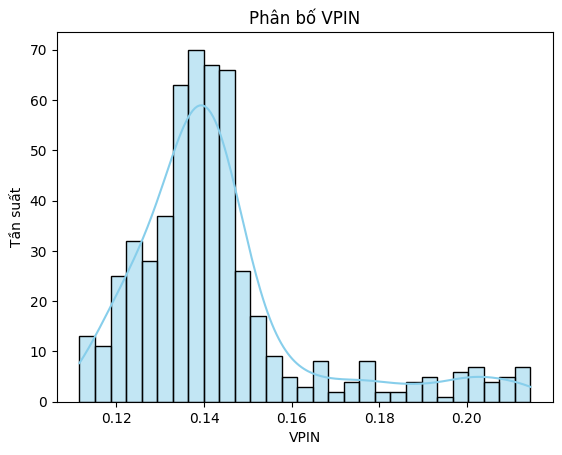

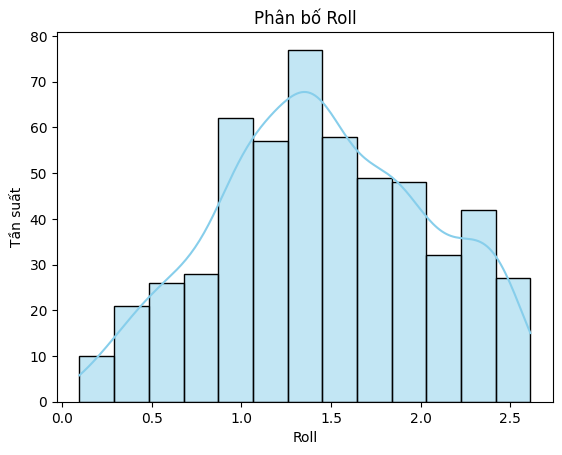

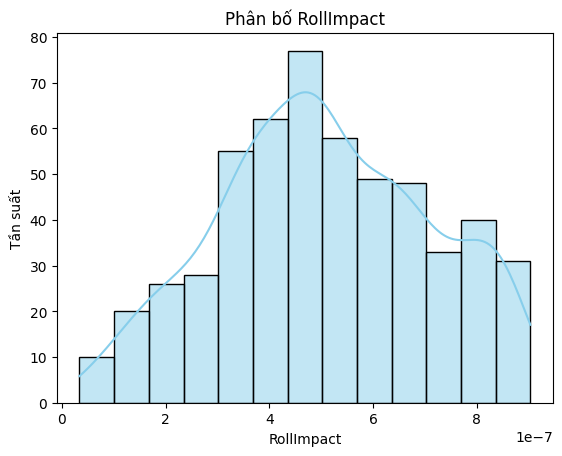

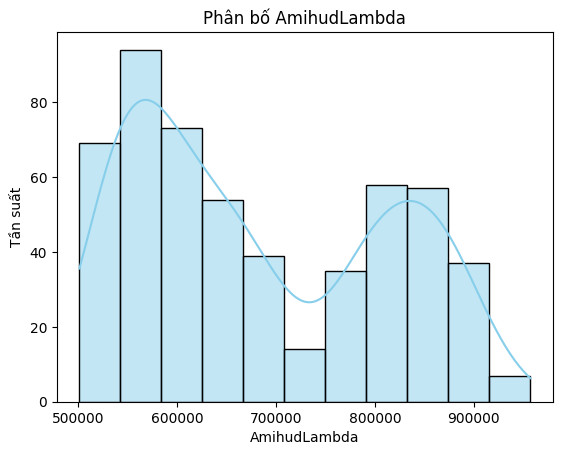

In [9]:
for col in lst_input:
    try:
        plt.Figure(figsize=(10, 6))
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Phân bố {col}')
        plt.xlabel(col)
        plt.ylabel('Tần suất')
        plt.show()
    except:
        pass

### Vẽ biểu đồ hộp - Boxplot của VPIN

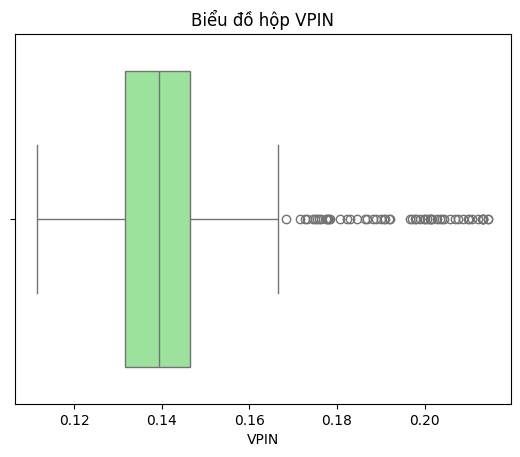

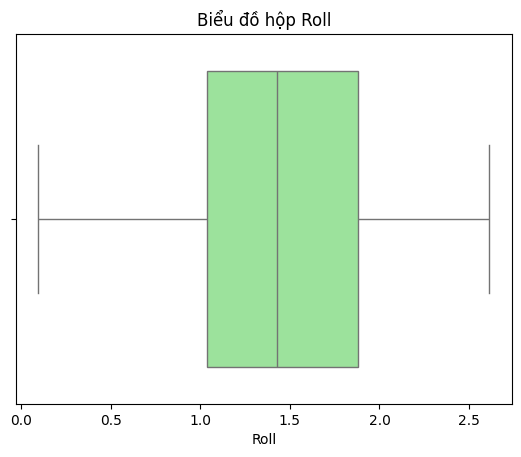

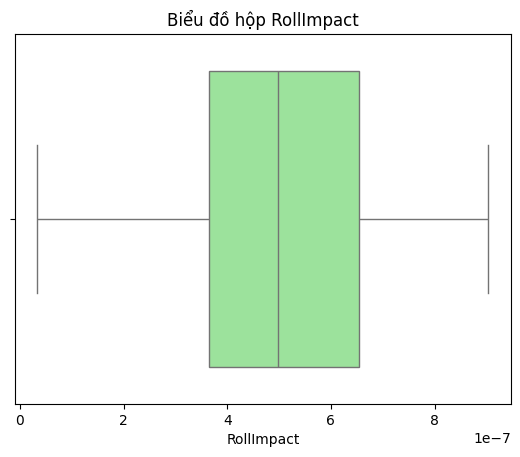

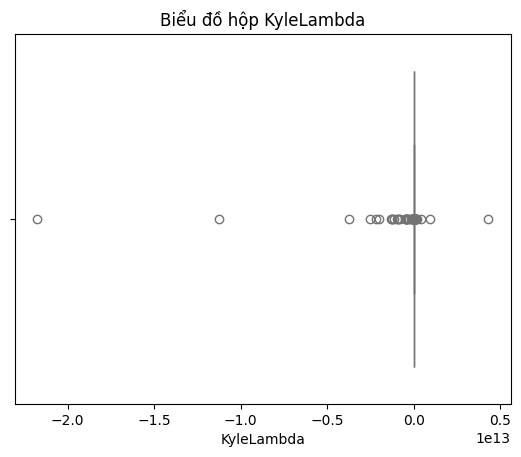

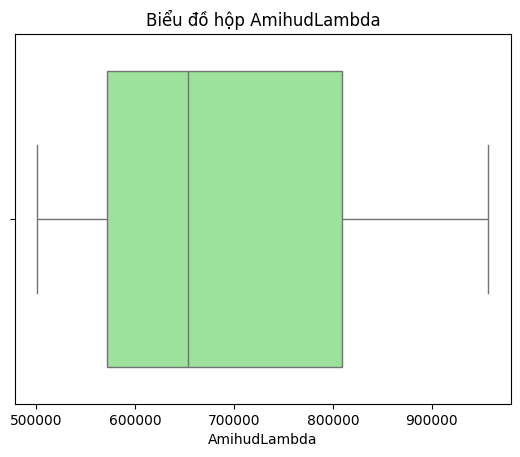

In [10]:
for col in lst_input:
    plt.Figure(figsize=(10, 6))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Biểu đồ hộp {col}')
    plt.xlabel(col)
    plt.show()

In [11]:
# def plot_vpin(buckets, col):
#     plt.figure(figsize=(12,6))
#     plt.plot(buckets["Time"].dt.floor('h'), buckets[col], label=f'{col}', linewidth=1.5)
#     plt.title(f"Xu hướng {col} the thời gian")
#     plt.xlabel("Thời gian")
#     plt.ylabel(col)
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.xticks(rotation=30)
#     plt.show()
# plot_vpin(df, "VPIN")


In [12]:
df[lst_input].corr()

,VPIN,Roll,RollImpact,KyleLambda,AmihudLambda
VPIN,1.000000,0.371413,0.383404,0.011431,-0.256869
Roll,0.371413,1.000000,0.999557,-0.018519,-0.284401
RollImpact,0.383404,0.999557,1.000000,-0.017919,-0.281452
KyleLambda,0.011431,-0.018519,-0.017919,1.000000,-0.040634
AmihudLambda,-0.256869,-0.284401,-0.281452,-0.040634,1.000000


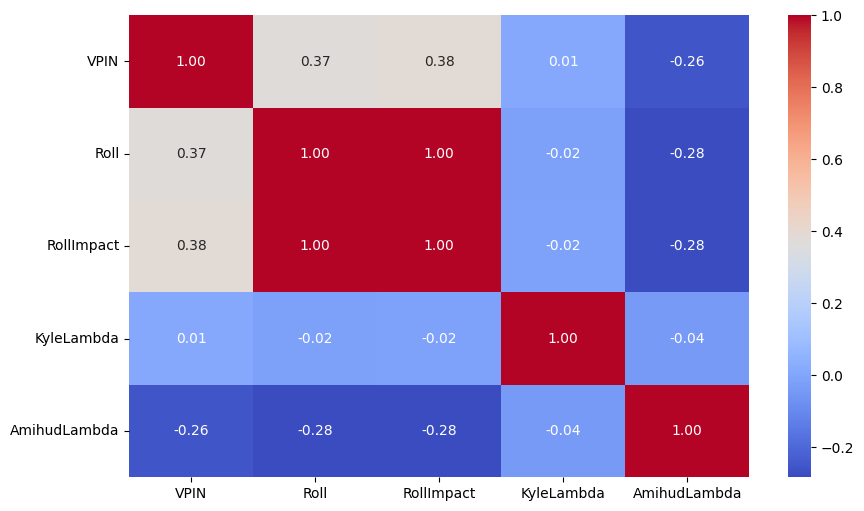

In [13]:
# heatmap:
plt.figure(figsize=(10, 6))
sns.heatmap(df[lst_input].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

<Figure size 1000x600 with 0 Axes>

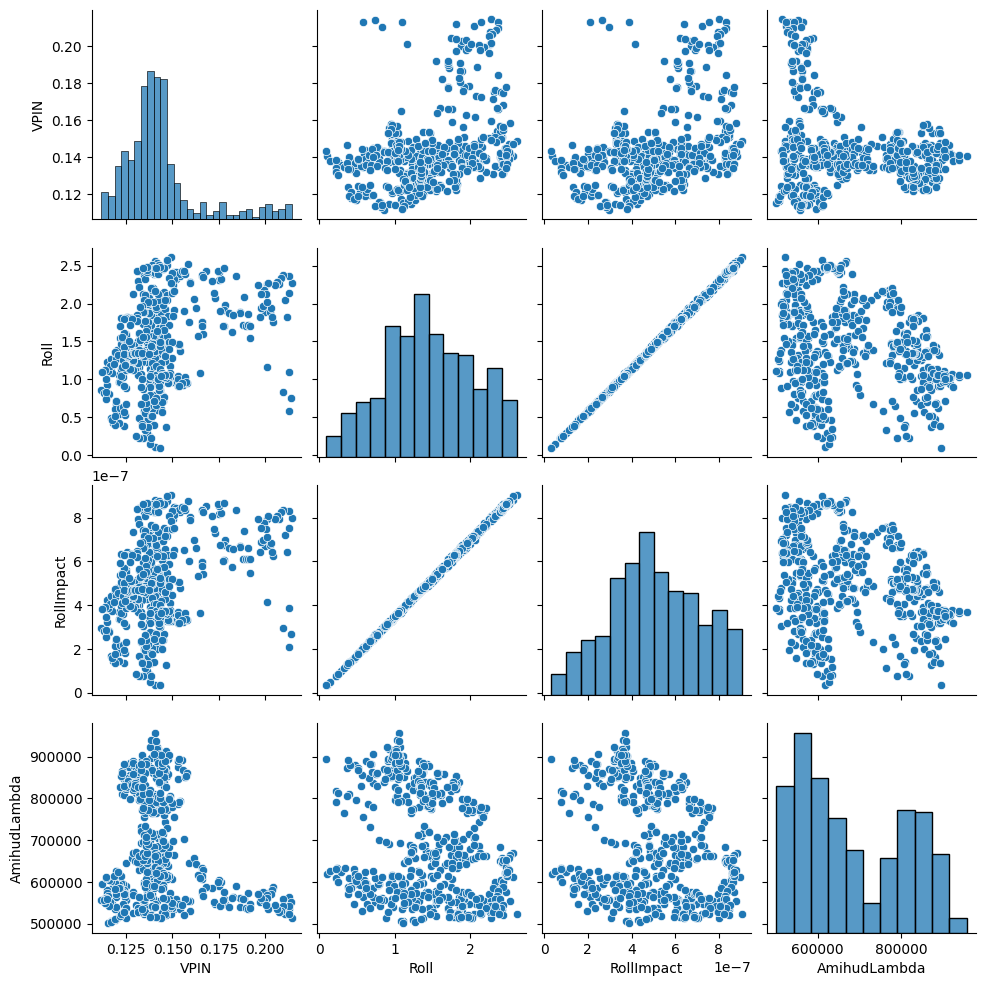

In [14]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.pairplot(df[['VPIN', 'Roll', 'RollImpact', 'AmihudLambda']])
plt.show()

# Phân tích mối quan hệ giữa VPIN và các biến mục tiêu

In [15]:
# List các biến mục tiêu
target_cols = list_output
# [
#     'SpreadChangeSign',
#     'RealizedVolatilitySign',
#     'JB_ChangeSign',
#     'AR_ChangeSign',
#     'SkewnessSign',
#     'KurtosisSign'

# ]

In [16]:
# Loại bỏ các dữ liệu Nan do việc tính toán các chỉ số thống kê cuộn
df = df.dropna(subset=target_cols + ['VPIN'])

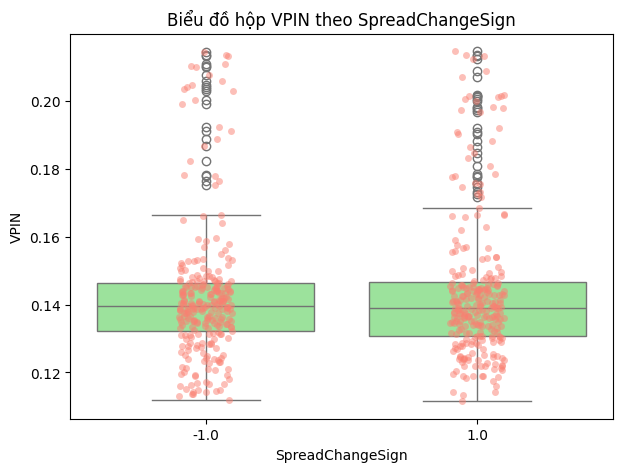

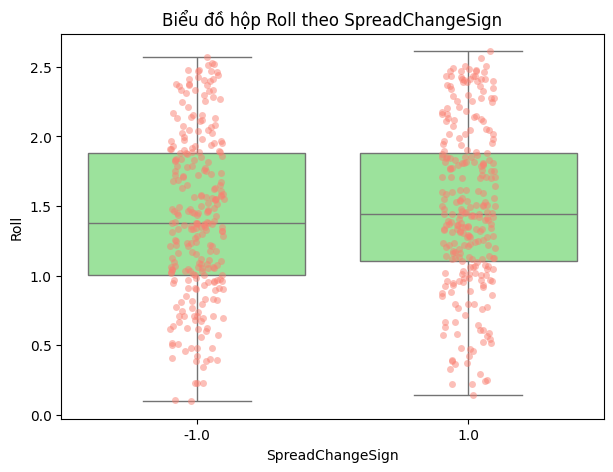

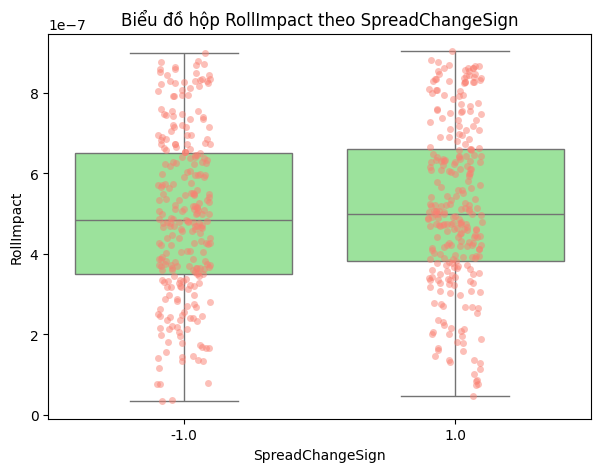

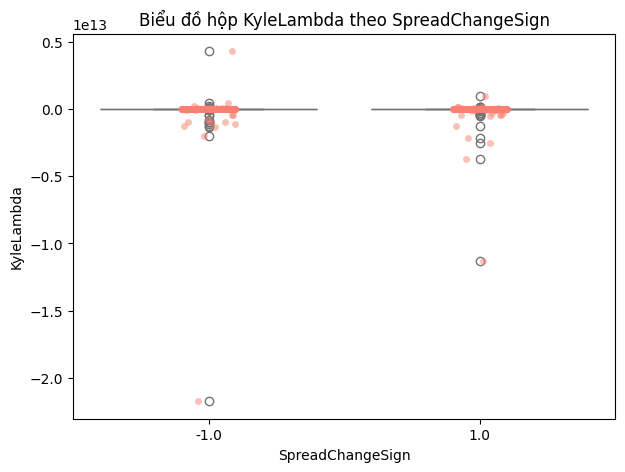

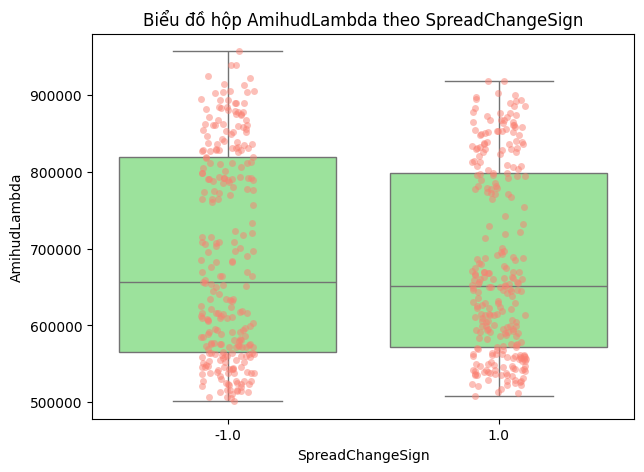

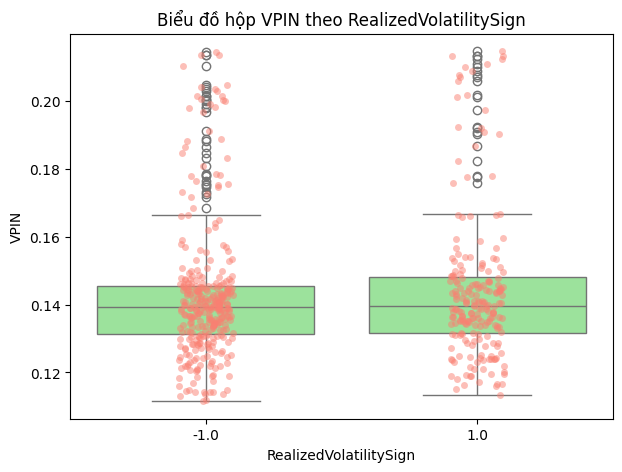

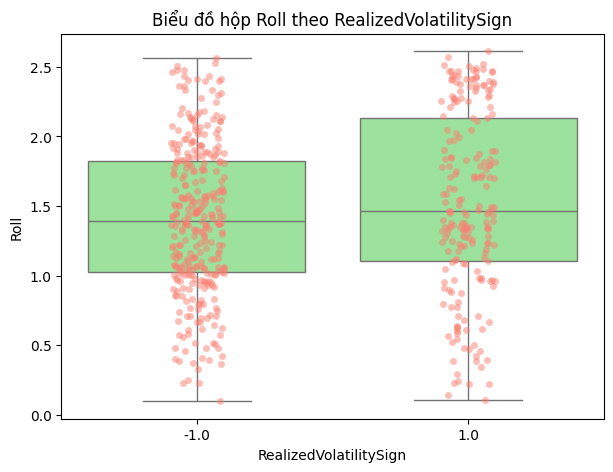

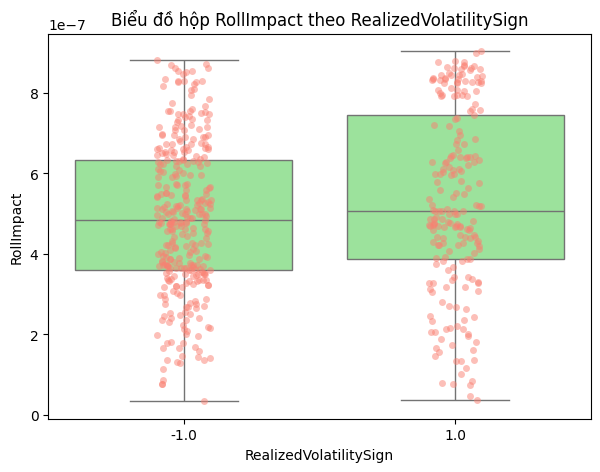

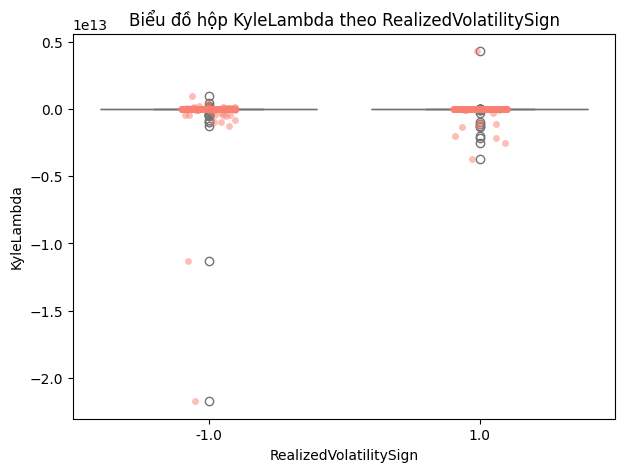

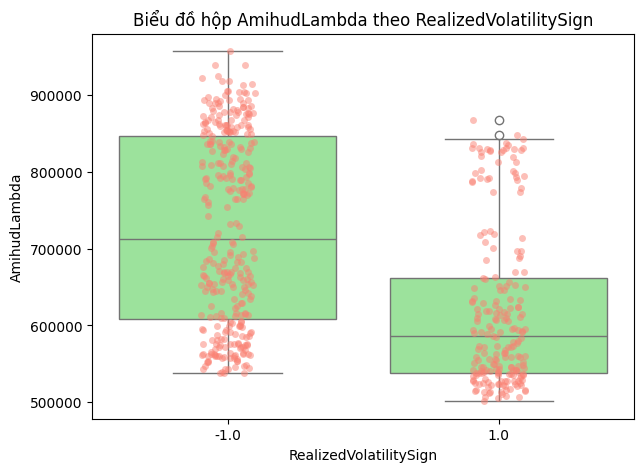

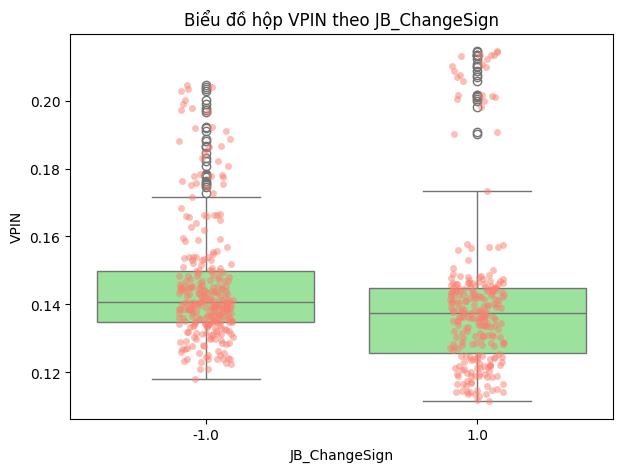

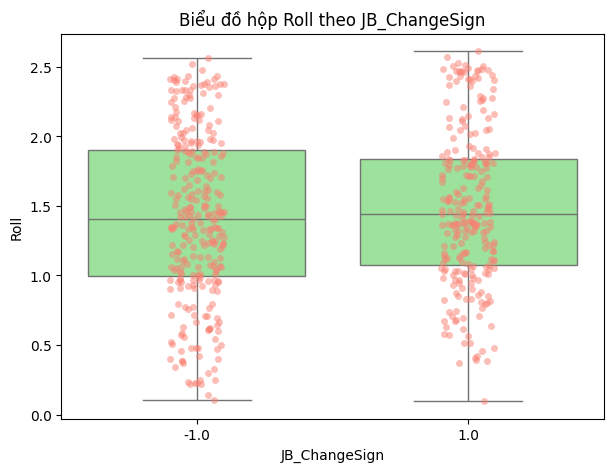

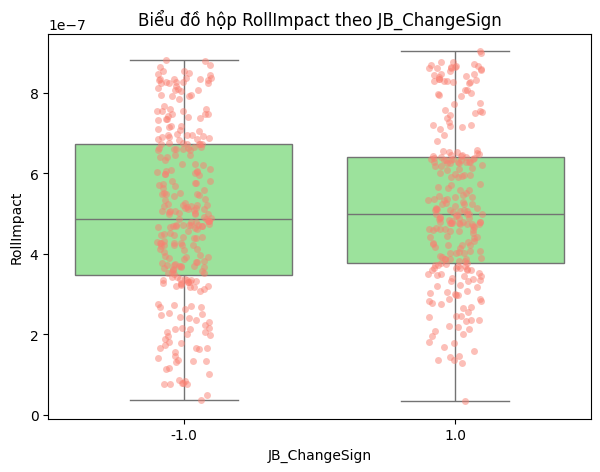

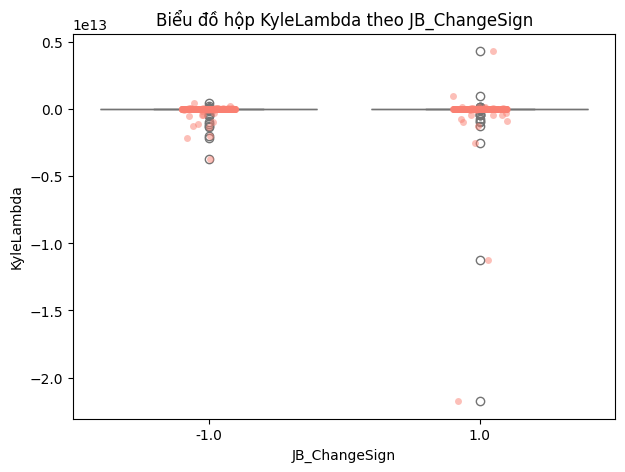

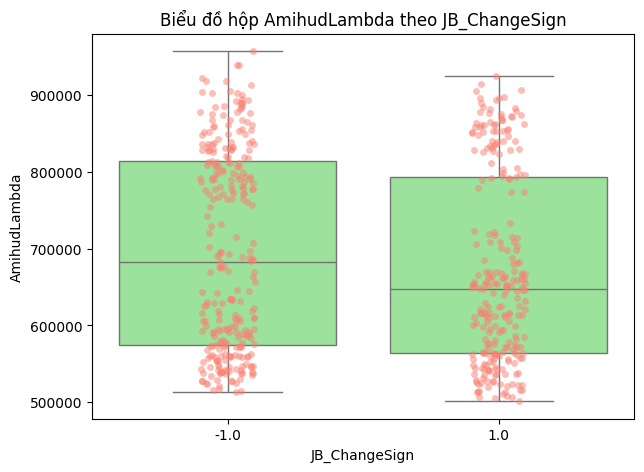

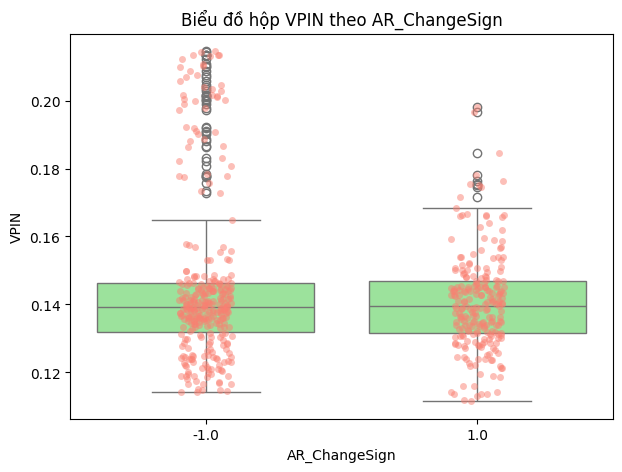

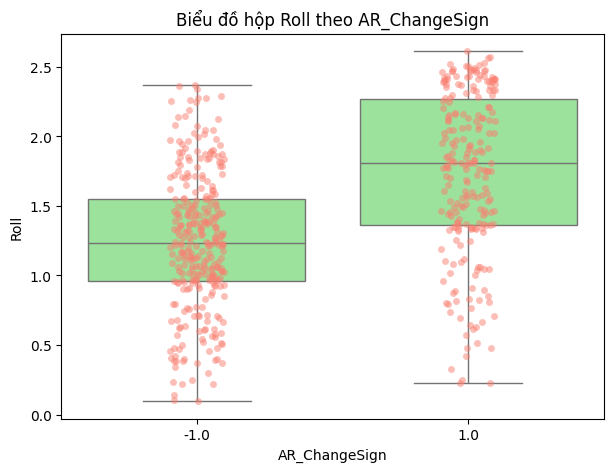

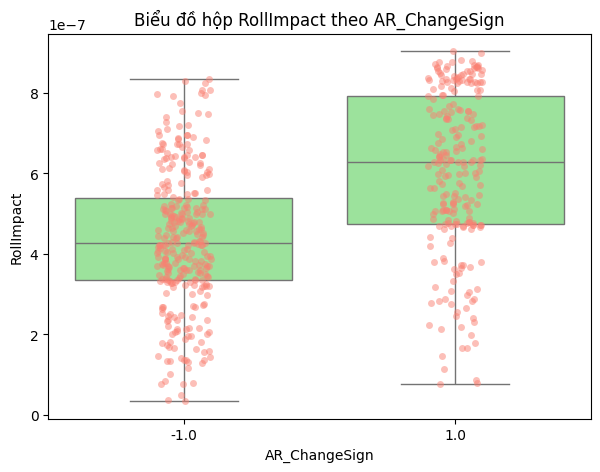

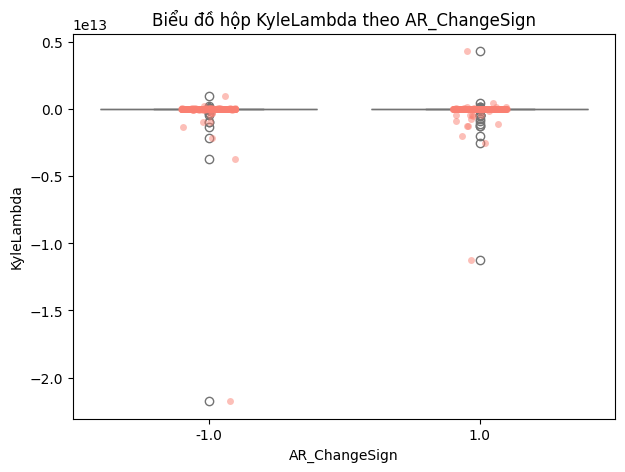

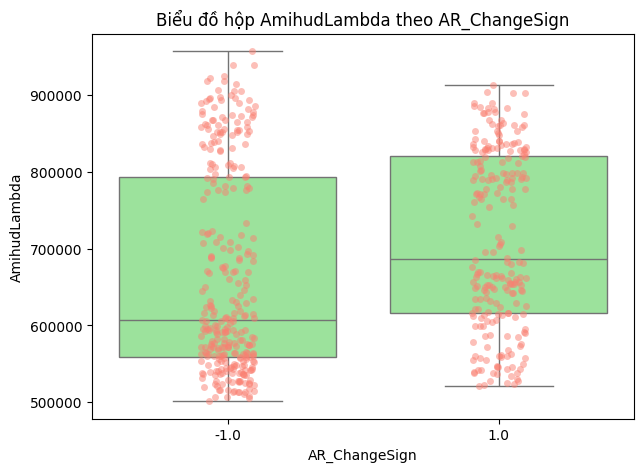

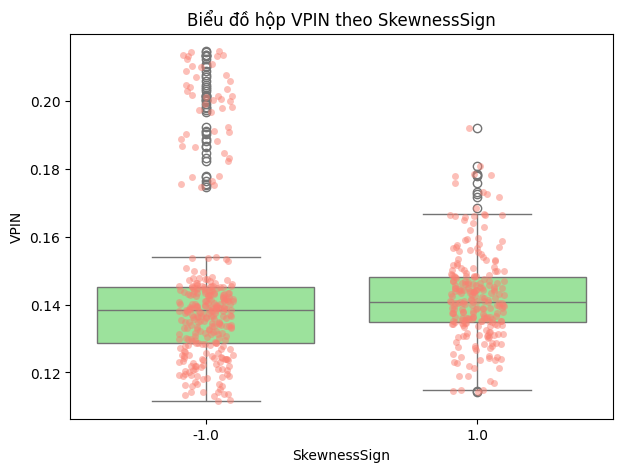

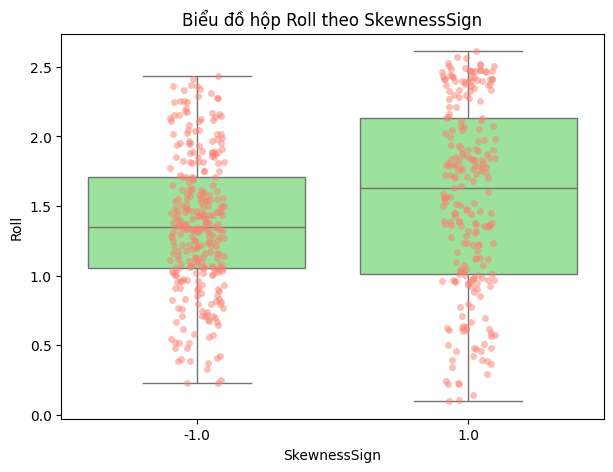

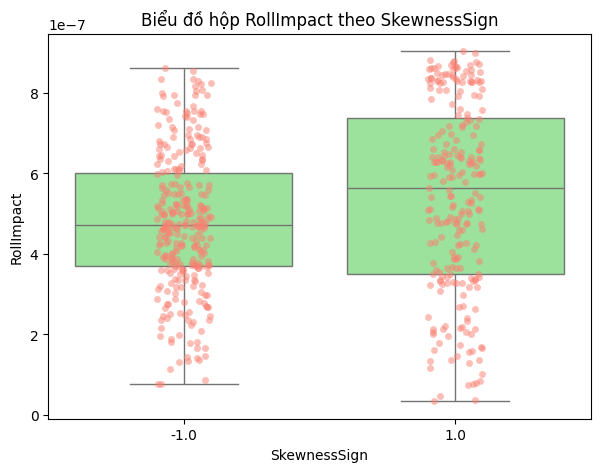

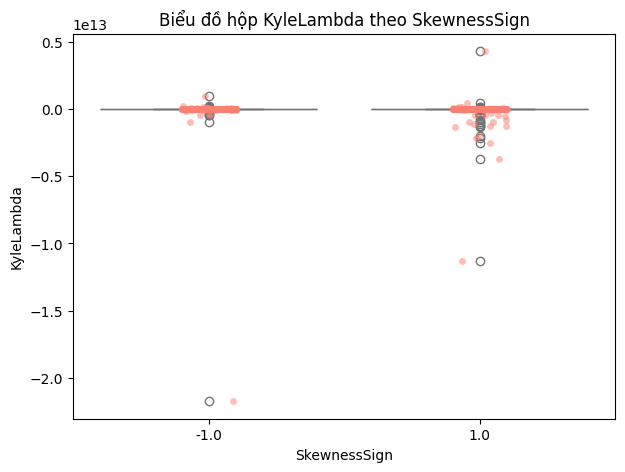

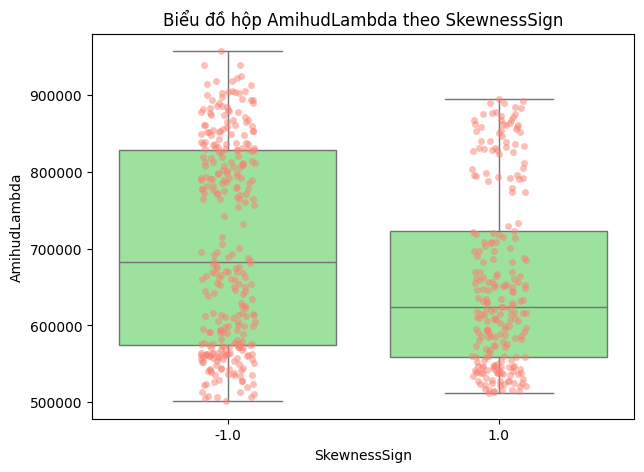

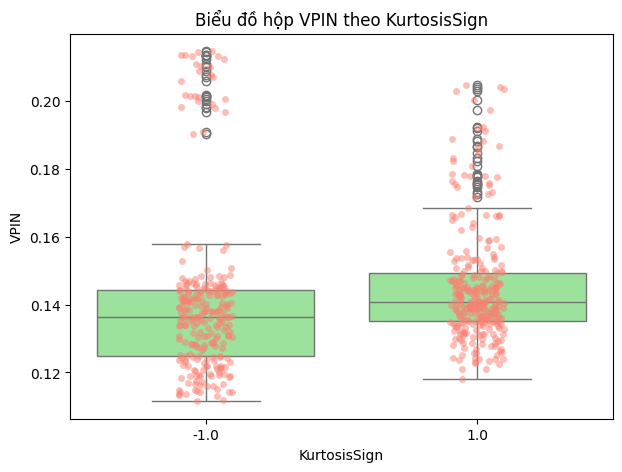

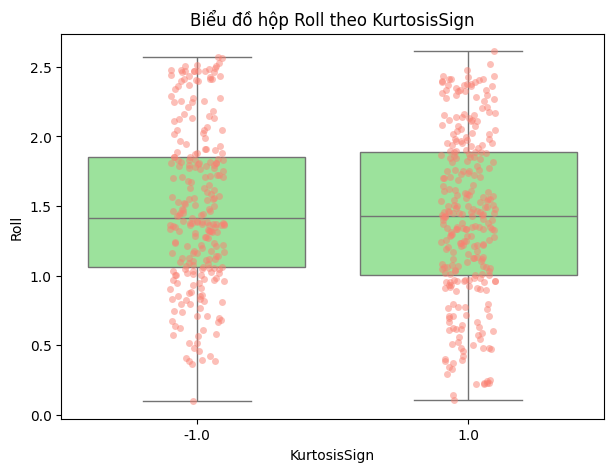

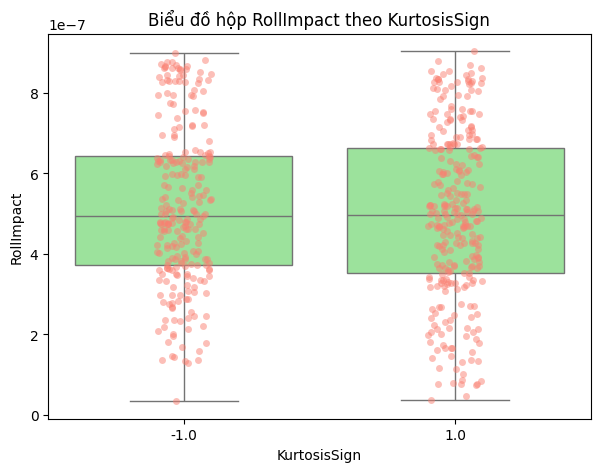

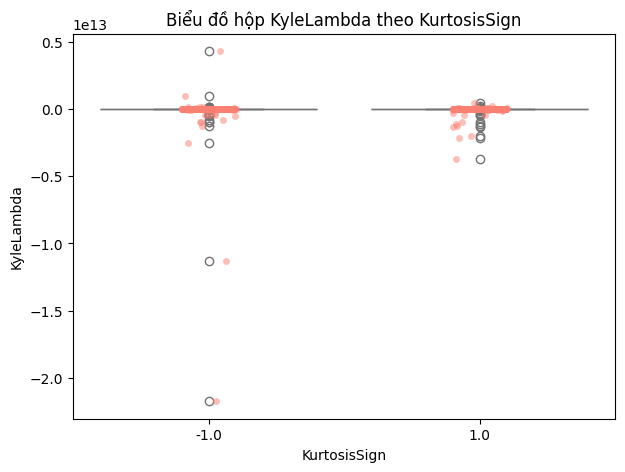

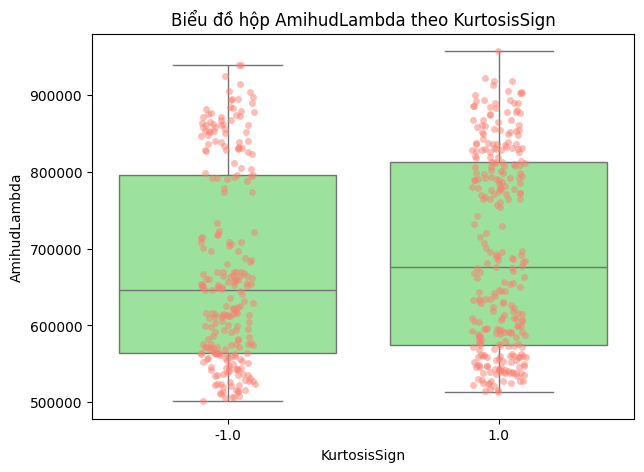

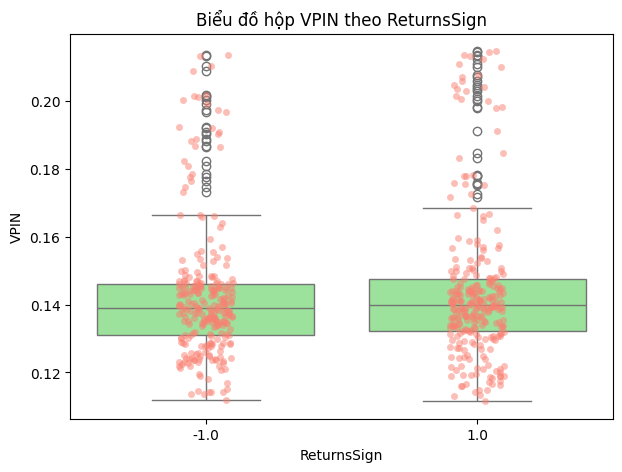

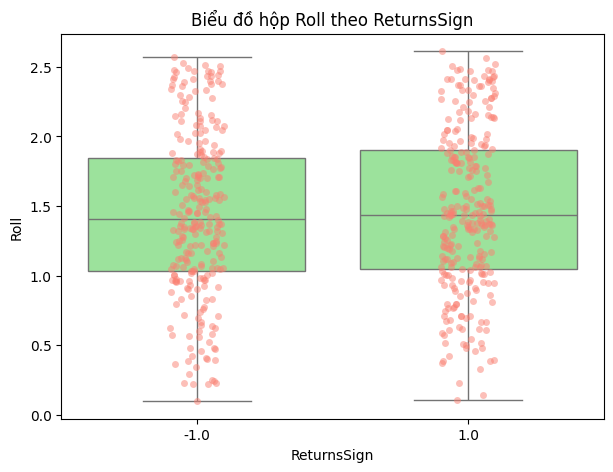

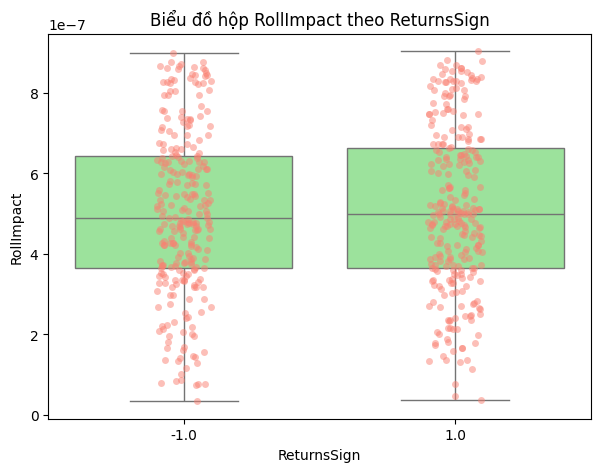

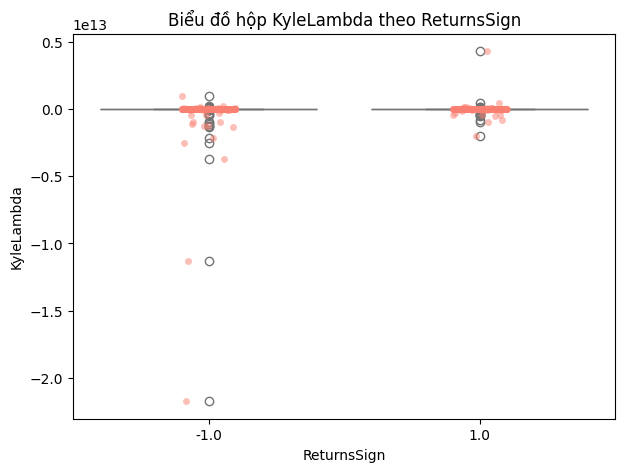

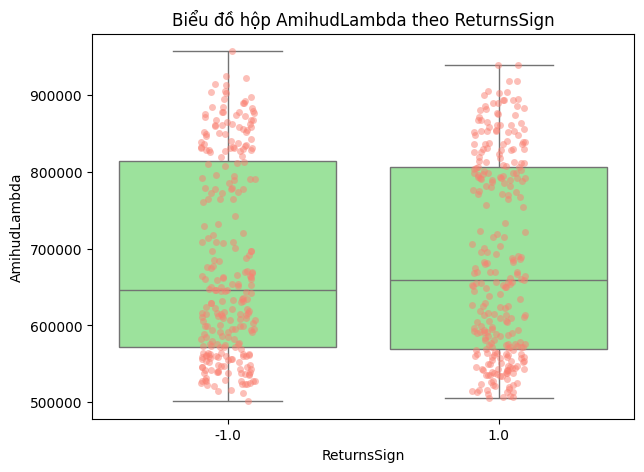

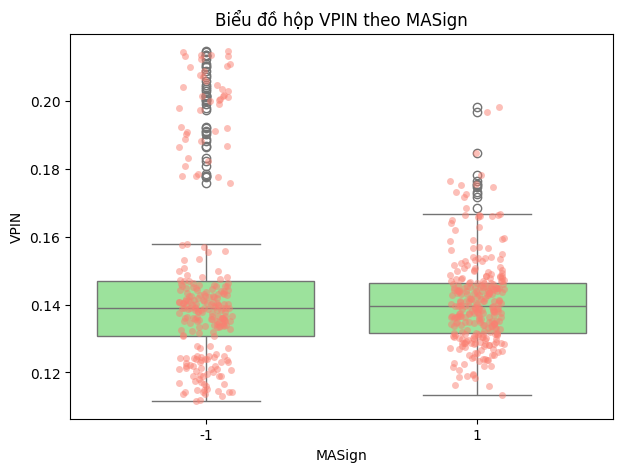

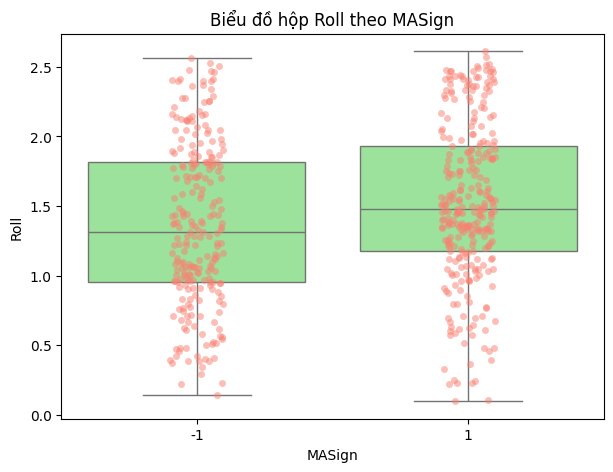

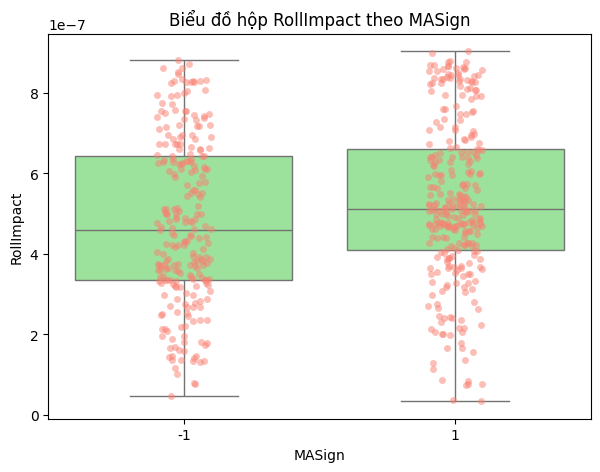

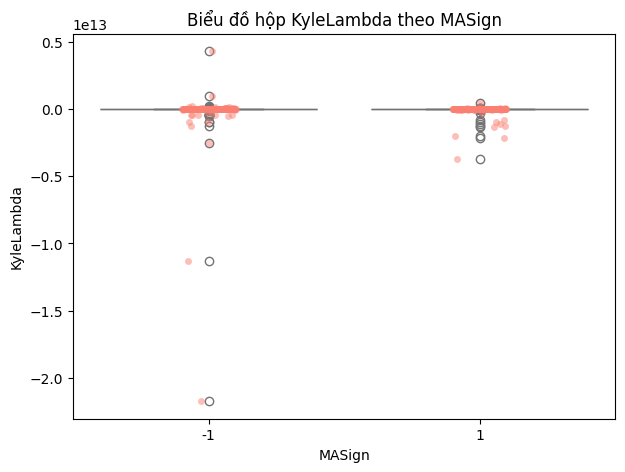

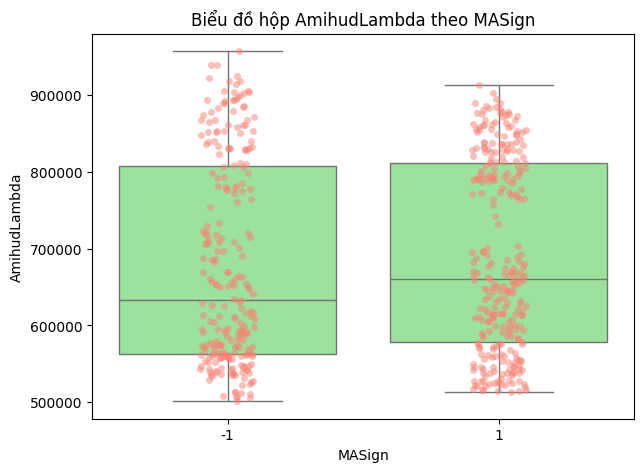

In [17]:
for col in target_cols:
    for col_in in lst_input:
        plt.figure(figsize=(7, 5))
        sns.boxplot(x=col, y=col_in, data=df, color='lightgreen')
        sns.stripplot(x=col, y=col_in, data=df, color='salmon', alpha=0.5, jitter=True)
        plt.title(f'Biểu đồ hộp {col_in} theo {col}')
        plt.show()

In [18]:
# for col in target_cols:
#     plt.figure(figsize=(6, 2))
#     sns.barplot(x=col, y='VPIN', data=df, color='lightgreen', errorbar=('ci', 95))
#     plt.title(f'Trung bình VPIN theo {col}')
#     plt.show()

# Kiểm định

### Kiểm tra phân phối của dữ liệu VPIN

- Giả thuyết H0: Dữ liệu VPIN tuân theo phân phối chuẩn
- Giả thuyết H1: Dữ liệu không tuân theo phân phối chuẩn.

In [19]:
for col in lst_input:
    print(col)
    stat, p = shapiro(df[col].dropna())
    print(f'Shapiro-Wilk test: p-value = {p}')


VPIN
Shapiro-Wilk test: p-value = 1.8623156689661617e-23
Roll
Shapiro-Wilk test: p-value = 4.8205200160286556e-06
RollImpact
Shapiro-Wilk test: p-value = 2.2621526589100278e-06
KyleLambda
Shapiro-Wilk test: p-value = 1.2467909824640465e-44
AmihudLambda
Shapiro-Wilk test: p-value = 2.4060390648917483e-17


In [20]:
stat, p = shapiro(np.log(df['VPIN'].dropna()))
p

np.float64(3.690177841475846e-19)

- p rất bé => Bác bỏ giả thuyết H0. Chưa đủ bằng chứng để kết luận rằng VPIN có phân phối chuẩn

### Kiểm tra phân phối của VPIN theo từng nhóm

- Giả thuyết H0: VPIN cho từng nhóm có phân phối chuẩn
- Giả thuyế H1: VPIN cho từng nhóm không có phân phối chuẩn

In [21]:
for col in target_cols:
    for col_in in lst_input:
        print(f"Kiểm định cho giá trị {col} - {col_in}")
        gr1 = df.loc[df[col] == 1, col_in]
        p1 = shapiro(gr1)[1]
        gr2 = df.loc[df[col] == -1, col_in]
        p2 = shapiro(gr1)[1]
        print(f"pvalue với {col} = 1 cho {col_in}: ", p1)
        print(f"pvalue với {col} = -1 cho {col_in}: ", p2)

Kiểm định cho giá trị SpreadChangeSign - VPIN
pvalue với SpreadChangeSign = 1 cho VPIN:  3.700752192510025e-16
pvalue với SpreadChangeSign = -1 cho VPIN:  3.700752192510025e-16
Kiểm định cho giá trị SpreadChangeSign - Roll
pvalue với SpreadChangeSign = 1 cho Roll:  0.0006398848147694426
pvalue với SpreadChangeSign = -1 cho Roll:  0.0006398848147694426
Kiểm định cho giá trị SpreadChangeSign - RollImpact
pvalue với SpreadChangeSign = 1 cho RollImpact:  0.00028238690327257585
pvalue với SpreadChangeSign = -1 cho RollImpact:  0.00028238690327257585
Kiểm định cho giá trị SpreadChangeSign - KyleLambda
pvalue với SpreadChangeSign = 1 cho KyleLambda:  9.512881790369472e-34
pvalue với SpreadChangeSign = -1 cho KyleLambda:  9.512881790369472e-34
Kiểm định cho giá trị SpreadChangeSign - AmihudLambda
pvalue với SpreadChangeSign = 1 cho AmihudLambda:  6.139076744827003e-12
pvalue với SpreadChangeSign = -1 cho AmihudLambda:  6.139076744827003e-12
Kiểm định cho giá trị RealizedVolatilitySign - VPIN
p

- Bác bỏ giả thuyết H0 rằng VPIN cho từng nhóm có phân phối chuẩn

- Dữ liệu VPIN và dữ liệu VPIN theo từng nhóm đều không có phân phối chuẩn, ta dùng kiểm định mannwhitneyu để kiểm định xem  giá trị VPIN có khác biệt giữa các nhóm phân loại hay không

In [22]:
for col in target_cols:
    for col_in in lst_input:
        print(f"Kiểm định cho giá trị {col} - {col_in}")
        gr1 = df.loc[df[col] == 1, col_in]
        gr2 = df.loc[df[col] == -1, col_in]
        stat, p = mannwhitneyu(gr1, gr2)
        print(f"pvalue Mann-Whitney U Test cột {col} - {col_in} : ", p)

Kiểm định cho giá trị SpreadChangeSign - VPIN
pvalue Mann-Whitney U Test cột SpreadChangeSign - VPIN :  0.9696039156932876
Kiểm định cho giá trị SpreadChangeSign - Roll
pvalue Mann-Whitney U Test cột SpreadChangeSign - Roll :  0.18765597906481613
Kiểm định cho giá trị SpreadChangeSign - RollImpact
pvalue Mann-Whitney U Test cột SpreadChangeSign - RollImpact :  0.18840238866781656
Kiểm định cho giá trị SpreadChangeSign - KyleLambda
pvalue Mann-Whitney U Test cột SpreadChangeSign - KyleLambda :  0.07348199460723563
Kiểm định cho giá trị SpreadChangeSign - AmihudLambda
pvalue Mann-Whitney U Test cột SpreadChangeSign - AmihudLambda :  0.6824349650368275
Kiểm định cho giá trị RealizedVolatilitySign - VPIN
pvalue Mann-Whitney U Test cột RealizedVolatilitySign - VPIN :  0.45612386893071566
Kiểm định cho giá trị RealizedVolatilitySign - Roll
pvalue Mann-Whitney U Test cột RealizedVolatilitySign - Roll :  0.024376992466265988
Kiểm định cho giá trị RealizedVolatilitySign - RollImpact
pvalue Mann

## Áp dụng model: RandomForest

### Chuẩn bị bộ dữ liệu

In [23]:
for col in target_cols:
    print(pd.DataFrame(df[col].value_counts()))

                  count
SpreadChangeSign       
 1.0                272
-1.0                265
                        count
RealizedVolatilitySign       
-1.0                      328
 1.0                      209
               count
JB_ChangeSign       
-1.0             283
 1.0             254
               count
AR_ChangeSign       
-1.0             307
 1.0             230
              count
SkewnessSign       
-1.0            300
 1.0            237
              count
KurtosisSign       
 1.0            288
-1.0            249
             count
ReturnsSign       
 1.0           273
-1.0           264
        count
MASign       
 1        293
-1        244


- Bộ dữ liệu có sự phân bố nhãn khá cân bằng giữa hai chiều giá trị (-1.0 và 1.0) ở các biến mục tiê. Mỗi biến đều có số lượng mẫu gần như tương đương giữa hai nhãn, với chênh lệch không đáng kể (dao động trong khoảng 2–14 mẫu). Điều này cho thấy bộ dữ liệu phù hợp để huấn luyện các mô hình học máy mà không cần xử lý mất cân bằng nhãn quá phức tạp.

In [24]:
train_data, test_data = {}, {}
for col in target_cols:
    data = df.copy()
    train_data[col], test_data[col] = train_test_split(data, test_size=0.3, random_state=42, stratify=data[col])
    

## Chỉ dùng VPIN làm biến đầu vào

In [25]:
train_cols = ["VPIN"]
model_info = {}
for col in list_output:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

Độ chính xác của mô hình cho SpreadChangeSign: 0.5062
              precision    recall  f1-score   support

        -1.0       0.50      0.56      0.53        80
         1.0       0.51      0.45      0.48        82

    accuracy                           0.51       162
   macro avg       0.51      0.51      0.50       162
weighted avg       0.51      0.51      0.50       162

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.5556
              precision    recall  f1-score   support

        -1.0       0.64      0.62      0.63        99
         1.0       0.43      0.46      0.45        63

    accuracy                           0.56       162
   macro avg       0.54      0.54      0.54       162
weighted avg       0.56      0.56      0.56       162

Độ chính xác của mô hình cho JB_ChangeSign: 0.6852
              precision    recall  f1-score   support

        -1.0       0.68      0.76      0.72        85
         1.0       0.70      0.60      0.64        77

    accuracy     

## Dùng tất cả các biến input

In [26]:
train_cols = lst_input
model_info = {}
for col in list_output:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

Độ chính xác của mô hình cho SpreadChangeSign: 0.5000
              precision    recall  f1-score   support

        -1.0       0.49      0.55      0.52        80
         1.0       0.51      0.45      0.48        82

    accuracy                           0.50       162
   macro avg       0.50      0.50      0.50       162
weighted avg       0.50      0.50      0.50       162

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.8333
              precision    recall  f1-score   support

        -1.0       0.83      0.91      0.87        99
         1.0       0.83      0.71      0.77        63

    accuracy                           0.83       162
   macro avg       0.83      0.81      0.82       162
weighted avg       0.83      0.83      0.83       162

Độ chính xác của mô hình cho JB_ChangeSign: 0.8765
              precision    recall  f1-score   support

        -1.0       0.87      0.91      0.89        85
         1.0       0.89      0.84      0.87        77

    accuracy     

### Mô hình XGBoost

In [27]:
train_cols = ["VPIN"]
for col in target_cols:
        # Khởi tạo mô hình XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        # use_label_encoder=False,
        eval_metric='logloss'
    )
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán và đánh giá
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(report)


Độ chính xác của mô hình cho SpreadChangeSign: 0.4691
              precision    recall  f1-score   support

           0       0.47      0.57      0.52        80
           1       0.47      0.37      0.41        82

    accuracy                           0.47       162
   macro avg       0.47      0.47      0.46       162
weighted avg       0.47      0.47      0.46       162

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.5988
              precision    recall  f1-score   support

           0       0.62      0.90      0.73        99
           1       0.44      0.13      0.20        63

    accuracy                           0.60       162
   macro avg       0.53      0.51      0.47       162
weighted avg       0.55      0.60      0.52       162

Độ chính xác của mô hình cho JB_ChangeSign: 0.6605
              precision    recall  f1-score   support

           0       0.64      0.79      0.71        85
           1       0.69      0.52      0.59        77

    accuracy     

In [28]:
train_cols = lst_input
for col in target_cols:
        # Khởi tạo mô hình XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        # use_label_encoder=False,
        eval_metric='logloss'
    )
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán và đánh giá
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Độ chính xác của mô hình: {accuracy:.4f}")
    print(report)


Độ chính xác của mô hình: 0.5062
              precision    recall  f1-score   support

           0       0.50      0.54      0.52        80
           1       0.51      0.48      0.49        82

    accuracy                           0.51       162
   macro avg       0.51      0.51      0.51       162
weighted avg       0.51      0.51      0.51       162

Độ chính xác của mô hình: 0.8086
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        99
           1       0.80      0.68      0.74        63

    accuracy                           0.81       162
   macro avg       0.81      0.79      0.79       162
weighted avg       0.81      0.81      0.81       162

Độ chính xác của mô hình: 0.8148
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        85
           1       0.81      0.81      0.81        77

    accuracy                           0.81       162
   macro avg       0.81      